<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/f-TEP2-Base/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [9]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy
#!pip install matplotlib==3.1.3
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-k2nga5qh
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-k2nga5qh
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simpsom 2.0.1 requires matplotlib>=3.3.3, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#importing all the necessary libraries 
!pip install pyreadr
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score,f1_score
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
import datetime
from tensorflow.keras.utils import to_categorical
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
#reading train data in .R format
#a1 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_FaultFree_Training.RData")
#a2 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_Faulty_Training.RData")
a1 = pd.read_csv("../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/test.csv")
a2 = pd.read_csv("../content/drive/MyDrive/DadosPWFTS/DataTEPCSV/train.csv")

#reading test data in .R format

#a3 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_FaultFree_Testing.RData")
#a4 = py.read_r("../content/drive/MyDrive/DadosPWFTS/TEP_Faulty_Testing (1).RData")

print("Objects that are present in a1 :",a1.keys())
print("Objects that are present in a2 :",a2.keys())
#print("Objects that are present in a3 :",a3.keys())
#print("Objects that are present in a4 :",a4.keys())

Objects that are present in a1 : Index(['Unnamed: 0', 'faultNumber', 'simulationRun', 'sample', 'xmeas_1',
       'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7',
       'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13',
       'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19',
       'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25',
       'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31',
       'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37',
       'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2',
       'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10',
       'xmv_11'],
      dtype='object')
Objects that are present in a2 : Index(['Unnamed: 0', 'faultNumber', 'simulationRun', 'sample', 'xmeas_1',
       'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7',
       'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', '

In [14]:
#REading the .Rdata files in pandas dataframe and saving it in .csv file
#reading train data
b1 = a1
b2 = a2
#b1 = a1['fault_free_training']
#b2 = a2['faulty_training']
#reading test data
#b3 = a3['fault_free_testing']
#b4 = a4['faulty_testing']

# concatinating the train and the test dataset
frames_tr = [b1]
train_ts = pd.concat(frames_tr)
frames_ts = [b2]
test = pd.concat(frames_ts)
#all_data_TEP = [train_ts,test]
#all_TEP = pd.concat(all_data_TEP)

In [15]:
print('Shape of the Train dataset:', train_ts.shape)
print("Shape of the Test dataset:", test.shape)

print("Distrubution of faults in train dataset:")
print(train_ts['faultNumber'].value_counts())

print("Distrubution of faults in test dataset:")
print(test['faultNumber'].value_counts())

Shape of the Train dataset: (104000, 56)
Shape of the Test dataset: (270400, 56)
Distrubution of faults in train dataset:
10    5000
11    5000
19    5000
18    5000
17    5000
16    5000
15    5000
14    5000
13    5000
12    5000
20    5000
1     5000
9     5000
8     5000
7     5000
6     5000
5     5000
4     5000
3     5000
2     5000
0     4000
Name: faultNumber, dtype: int64
Distrubution of faults in test dataset:
0.0     40000
11.0    11520
19.0    11520
18.0    11520
17.0    11520
16.0    11520
15.0    11520
14.0    11520
13.0    11520
12.0    11520
10.0    11520
1.0     11520
9.0     11520
8.0     11520
7.0     11520
6.0     11520
5.0     11520
4.0     11520
3.0     11520
2.0     11520
20.0    11520
Name: faultNumber, dtype: int64


In [29]:
#train_ts_2 = train_ts[0:50000]
test_2 = test.loc[test['faultNumber']==4] #funciona filtro dados
#test_2 = test_2[0:50000]
test_sf = test.loc[test['faultNumber']==0]
print(test_2)
print(test_sf)

       Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
74560        1520          4.0            1.0      21  0.27833   3649.7   
74561        1521          4.0            1.0      22  0.27992   3647.2   
74562        1522          4.0            1.0      23  0.24735   3648.7   
74563        1523          4.0            1.0      24  0.24847   3677.2   
74564        1524          4.0            1.0      25  0.23392   3732.0   
...           ...          ...            ...     ...      ...      ...   
86075      231995          4.0           24.0     496  0.30753   3669.6   
86076      231996          4.0           24.0     497  0.26735   3717.4   
86077      231997          4.0           24.0     498  0.26611   3718.2   
86078      231998          4.0           24.0     499  0.26000   3649.5   
86079      231999          4.0           24.0     500  0.25971   3684.5   

       xmeas_3  xmeas_4  xmeas_5  xmeas_6  ...   xmv_2   xmv_3   xmv_4  \
74560   4479.9   9.3455  

In [24]:
i = 0 
for i in range(20):
  test_3 = test_2.loc[test_2['simulationRun']==i] #funciona filtro dados
  print(i)
  print(test_3)

0
Empty DataFrame
Columns: [Unnamed: 0, faultNumber, simulationRun, sample, xmeas_1, xmeas_2, xmeas_3, xmeas_4, xmeas_5, xmeas_6, xmeas_7, xmeas_8, xmeas_9, xmeas_10, xmeas_11, xmeas_12, xmeas_13, xmeas_14, xmeas_15, xmeas_16, xmeas_17, xmeas_18, xmeas_19, xmeas_20, xmeas_21, xmeas_22, xmeas_23, xmeas_24, xmeas_25, xmeas_26, xmeas_27, xmeas_28, xmeas_29, xmeas_30, xmeas_31, xmeas_32, xmeas_33, xmeas_34, xmeas_35, xmeas_36, xmeas_37, xmeas_38, xmeas_39, xmeas_40, xmeas_41, xmv_1, xmv_2, xmv_3, xmv_4, xmv_5, xmv_6, xmv_7, xmv_8, xmv_9, xmv_10, xmv_11]
Index: []

[0 rows x 56 columns]
1
       Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
74560        1520          4.0            1.0      21  0.27833   3649.7   
74561        1521          4.0            1.0      22  0.27992   3647.2   
74562        1522          4.0            1.0      23  0.24735   3648.7   
74563        1523          4.0            1.0      24  0.24847   3677.2   
74564        1524          4.0    

In [31]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

In [30]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

dff = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosFalha.xlsx')
dfn = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosNormais.xlsx')

dados_treino_Falha = dff[0:2300] 
dados_teste_Falha = dff[1800:2300]

dados_treino_Normal = dfn[0:1800] 
dados_teste_Normal = dfn[1500:1800]

print(test_2)
print(test_sf)

## Analisando as Séries Temporais

In [32]:
#Dados sem Falhas

from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets1 = {}

#datasets1['LIT'] = dados_treino_Falha.get('LIT_2012KS_0251_FilteredSignal')
datasets1['LIT'] = test_sf.get('xmeas_6')
#datasets1['SpeedActual'] = dados_treino_Falha.get('_AL_2012KS_06M1_SpeedActual')
datasets1['SpeedActual'] = test_sf.get('xmeas_7')
#datasets1['BeltLoad'] = dados_treino_Falha.get('WIT_1085KS_2300_BeltLoad')
datasets1['BeltLoad'] = test_sf.get('xmeas_8')
#datasets1['Rate'] = dados_treino_Falha.get('WIT_1085KS_2300_Rate')
datasets1['Rate'] = test_sf.get('xmeas_9')

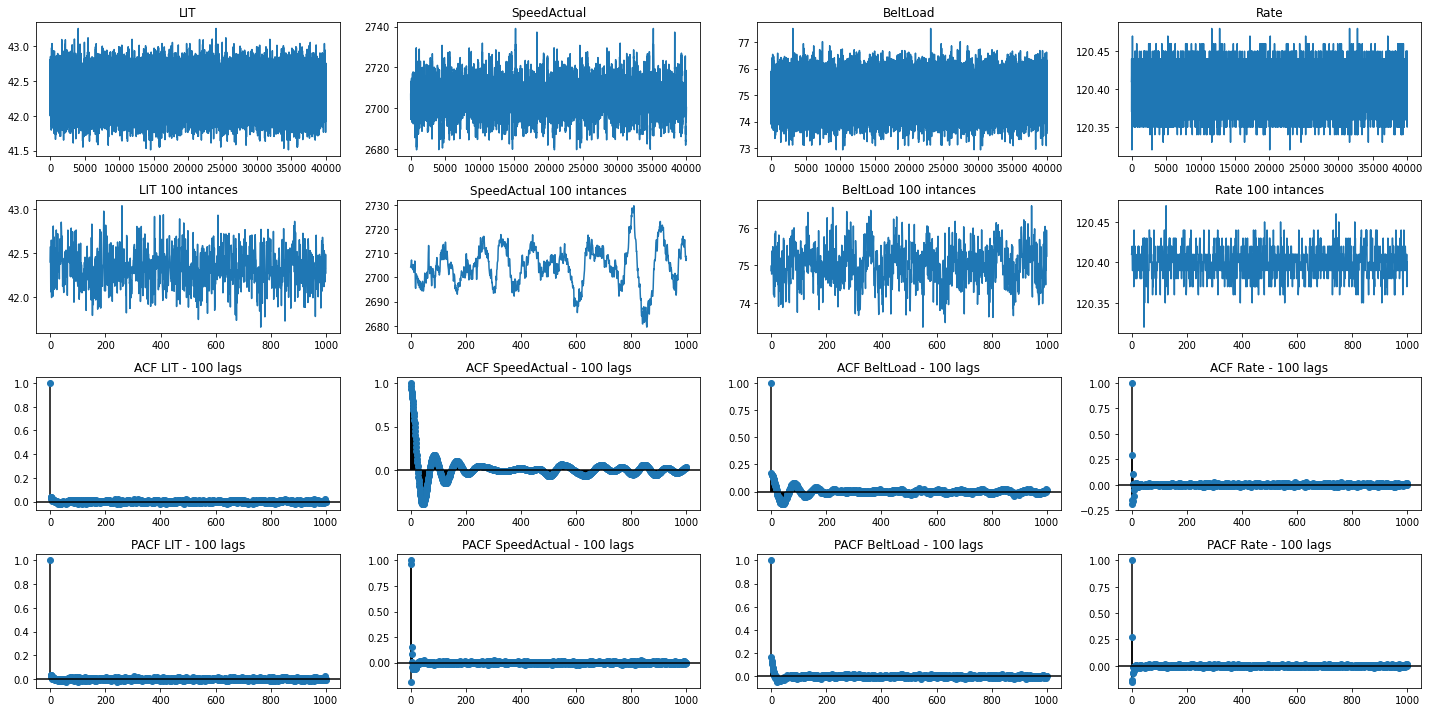

In [33]:
#Dados sem Falhas

fig1, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets1.items()): 
  _lags = np.arange(0,1001)
  _acf = acf(data,nlags=1000)
  _pacf = pacf(data,nlags=1000)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:1000])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

In [36]:
#Dados normais - com falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets2 = {}

#datasets2['LIT'] = dados_treino_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets2['LIT'] = test_2.get('xmeas_6')
#datasets2['SpeedActual'] = dados_treino_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets2['SpeedActual'] = test_2.get('xmeas_7')
#datasets2['BeltLoad'] = dados_treino_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets2['BeltLoad'] = test_2.get('xmeas_8')
#datasets2['Rate'] = dados_treino_Normal.get('WIT_1085KS_2300_Rate')
datasets2['Rate'] = test_2.get('xmeas_9')

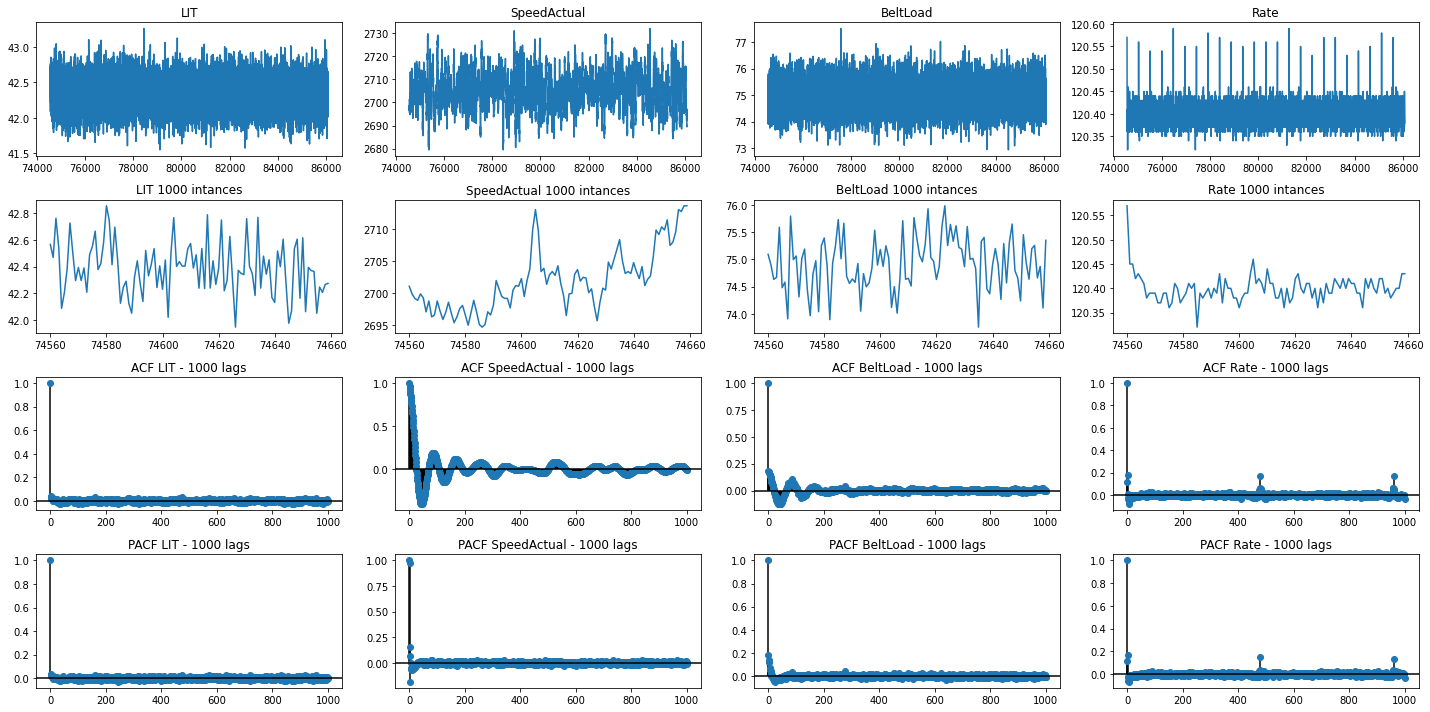

In [37]:
#Dados normais - com falhas

fig2, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets2.items()): 
  _lags = np.arange(0,1001)
  _acf = acf(data,nlags=1000)
  _pacf = pacf(data,nlags=1000)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 1000 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 1000 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 1000 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,Entropy,7.7,0.23,3.95


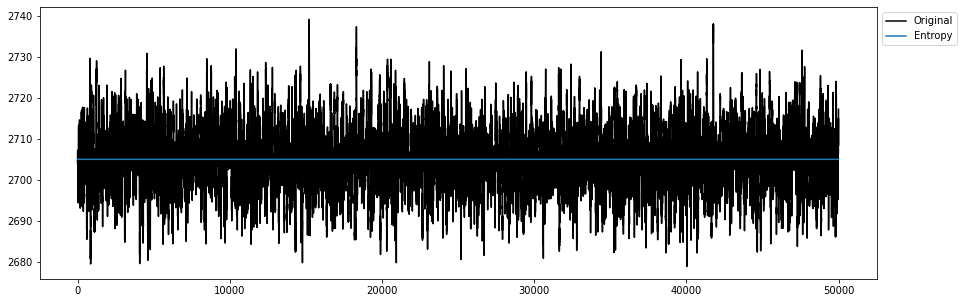

In [14]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

#metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]
metodos = [Entropy.EntropyPartitioner]

k = 4

rows = []

y1=np.asarray(datasets1['SpeedActual'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y1, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y1, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y1)
  forecasts = model.predict(y1)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y1, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

In [49]:
for i in range(40): 
  print(i) 
  grpan = test_sf.loc[test_sf['simulationRun'] == i+1]
  print(grpan['xmeas_6'])

0
0        42.402
1        42.576
2        42.070
3        42.063
4        42.650
          ...  
20495    42.312
20496    42.434
20497    42.536
20498    42.317
20499    42.757
Name: xmeas_6, Length: 1000, dtype: float64
1
500      42.420
501      41.890
502      42.299
503      42.034
504      42.069
          ...  
20995    42.174
20996    42.428
20997    42.321
20998    42.488
20999    42.277
Name: xmeas_6, Length: 1000, dtype: float64
2
1000     42.294
1001     42.708
1002     42.324
1003     42.467
1004     42.581
          ...  
21495    42.253
21496    42.094
21497    42.101
21498    41.706
21499    42.385
Name: xmeas_6, Length: 1000, dtype: float64
3
1500     42.359
1501     42.441
1502     42.053
1503     42.495
1504     42.378
          ...  
21995    42.365
21996    42.919
21997    42.237
21998    42.368
21999    42.579
Name: xmeas_6, Length: 1000, dtype: float64
4
2000     42.278
2001     42.190
2002     42.488
2003     42.258
2004     42.192
          ...  
22495    42.64

In [51]:
#Dados Sem Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = test_sf
tam_grupo = 1000
i=0
VT1=[]
V1=[] 

#for i in range(0,y1.size,tam_grupo):
for i in range(40):  
  grpan = test_sf.loc[test_sf['simulationRun'] == i+1]
  part = Grid.GridPartitioner(data=np.asarray(grpan['xmeas_6']), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(data)) 
  # model1.fit(np.asarray(y1))   
  print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VT1 = V1
  else:
    VT1 = np.c_[VT1,V1]

  print(lhs1t)
  print(rhs1)
  print(i)

VT1 = np.transpose(VT1)
print(VT1)

Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
0
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
1
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
2
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
3
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
4
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
5
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
6
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
7
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
8
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
9
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
10
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
11
Probabilistic FTS:
(1.0) A

In [52]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = test_sf
tam_grupo = 1000
i=0
VT2=[]
V2=[]
#for i in range(0,y2.size,tam_grupo):
for i in range(40):
  grpan = test_sf.loc[test_sf['simulationRun'] == i+1]
  part = Grid.GridPartitioner(data=np.asarray(grpan['xmeas_7']), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(data))  
  #  model2.fit(np.asarray(y2))  
  print(model2)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VT2 = V2
  else:
    VT2 = np.c_[VT2,V2]

  print(lhs2t)
  print(rhs2)
  print(i)

VT2 = np.transpose(VT2)
print(VT2)

Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
3
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
4
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
5
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
6
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
7
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
8
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
9
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
10
Probabilistic FTS:
(1.0) A0 -> (1.0)A0

[1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
11
Probabilistic FTS:
(1.0) A

In [54]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = test_sf
tam_grupo = 1000
i=0
VT3=[]
V3=[]

#for i in range(0,y3.size,tam_grupo):
for i in range(40):
  #grpan = y3[i:i+tam_grupo]
  grpan = test_sf.loc[test_sf['simulationRun'] == i+1]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan['xmeas_8']), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(np.asarray(data)))
    #model3.fit(np.asarray(y3))  
  print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VT3 = V3
  else:
    VT3 = np.c_[VT3,V3]

  print(lhs3t)
  print(rhs3)
  print(i)

VT3 = np.transpose(VT3)
print(VT3)


Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
0
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
1
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
2
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
3
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
4
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
5
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
6
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
7
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
8
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
9
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
10
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
11
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0. 0. 1.]]
12
Probabilistic FTS:
(1.0) A9 -> (1.0)A9

[1.]
[[0. 0. 0. 0. 0.

In [20]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets2['Rate']
tam_grupo = 5000
i=0
VT4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VT4 = V4
  else:
    VT4 = np.c_[VT4,V4]

  print(lhs4t)
  print(rhs4)
  print(i)

VT4 = np.transpose(VT4)
print(VT4)

ValueError: ignored

In [21]:
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets1['LIT']
tam_grupo = 5000
i=0
VU1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VU1 = V1
  else:
    VU1 = np.c_[VU1,V1]
    
  print(lhs1t)
  print(rhs1)
  print(i)

VU1 = np.transpose(VU1)
print(VU1)

[0.15822229 0.15550299 0.16123091 0.15770025 0.1577916  0.10477598
 0.10477598]
[[0.10481783 0.16036338 0.15855532 0.15573177 0.15756627 0.1581476
  0.10481783]
 [0.1047931  0.16078107 0.15820665 0.15539158 0.15734488 0.15868963
  0.1047931 ]
 [0.10497329 0.15991276 0.15802279 0.15571553 0.1585023  0.15790004
  0.10497329]
 [0.10480093 0.16015317 0.15803205 0.15586749 0.15723453 0.15911089
  0.10480093]
 [0.10479957 0.1599524  0.1581384  0.15570733 0.15783141 0.1587713
  0.10479957]
 [0.10491832 0.15979019 0.15789046 0.15551043 0.15749702 0.15947526
  0.10491832]
 [0.10491832 0.15979019 0.15789046 0.15551043 0.15749702 0.15947526
  0.10491832]]
0
[0.15863937 0.15737346 0.16019485 0.15732516 0.15685973 0.10480371
 0.10480371]
[[0.10486009 0.15929354 0.15892839 0.15763345 0.1565861  0.15783834
  0.10486009]
 [0.10481522 0.15974948 0.15860473 0.15728801 0.15635732 0.15837002
  0.10481522]
 [0.10501656 0.15887303 0.1584     0.15760926 0.15751255 0.15757203
  0.10501656]
 [0.10483325 0.1591

In [22]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets1['SpeedActual']
tam_grupo = 5000
i=0
VU2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VU2 = V2
  else:
    VU2 = np.c_[VU2,V2]

  print(lhs2t)
  print(rhs2)
  print(i)

VU2 = np.transpose(VU2)
print(VU2)

[0.14863357 0.14622974 0.14638088 0.13312447 0.13312447 0.1456653
 0.14684157]
[[0.13127726 0.18199093 0.15318789 0.1353088  0.13161728 0.13534057
  0.13127726]
 [0.12887803 0.15549671 0.16844613 0.15160898 0.13343962 0.13325251
  0.12887803]
 [0.12863916 0.13703566 0.15129941 0.16707351 0.15081629 0.13649681
  0.12863916]
 [0.14144533 0.14631268 0.14163719 0.14163458 0.14154654 0.14597836
  0.14144533]
 [0.14144533 0.14631268 0.14163719 0.14163458 0.14154654 0.14597836
  0.14144533]
 [0.12934398 0.13405569 0.13402548 0.15157904 0.16742077 0.15423107
  0.12934398]
 [0.13236502 0.13677982 0.13281063 0.13613081 0.15307808 0.17647062
  0.13236502]]
0
[0.14818664 0.14548542 0.13474768 0.13474768 0.14544189 0.14468431
 0.14670639]
[[0.1331512  0.17444031 0.15139017 0.13688422 0.13357233 0.13741057
  0.1331512 ]
 [0.13107056 0.15422566 0.16275073 0.14983105 0.13533569 0.13571576
  0.13107056]
 [0.14137723 0.1464671  0.14162181 0.14157016 0.14153264 0.14605383
  0.14137723]
 [0.14137723 0.146

In [23]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets1['BeltLoad']
tam_grupo = 5000
i=0
VU3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  print(model3)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VU3 = V3
  else:
    VU3 = np.c_[VU3,V3]

  print(lhs3t)
  print(rhs3)
  print(i)

VU3 = np.transpose(VU3)
print(VU3)

Probabilistic FTS:
(0.106) A0 -> (0.106)A0, (0.16)A1, (0.157)A2, (0.156)A3, (0.157)A4, (0.157)A5, (0.106)A6
(0.16) A1 -> (0.106)A0, (0.16)A1, (0.158)A2, (0.156)A3, (0.157)A4, (0.156)A5, (0.106)A6
(0.158) A2 -> (0.106)A0, (0.16)A1, (0.158)A2, (0.156)A3, (0.157)A4, (0.157)A5, (0.106)A6
(0.155) A3 -> (0.105)A0, (0.16)A1, (0.158)A2, (0.156)A3, (0.158)A4, (0.158)A5, (0.105)A6
(0.157) A4 -> (0.106)A0, (0.159)A1, (0.157)A2, (0.156)A3, (0.158)A4, (0.159)A5, (0.106)A6
(0.158) A5 -> (0.106)A0, (0.158)A1, (0.157)A2, (0.156)A3, (0.158)A4, (0.159)A5, (0.106)A6
(0.106) A6 -> (0.106)A0, (0.16)A1, (0.157)A2, (0.156)A3, (0.157)A4, (0.157)A5, (0.106)A6

[0.15976781 0.10589108 0.10589108 0.15797353 0.1546722  0.15740661
 0.15839768]
[[0.10622661 0.16015683 0.15808907 0.15628913 0.1569967  0.15601505
  0.10622661]
 [0.10640244 0.15988849 0.15741295 0.15594294 0.15686085 0.15708987
  0.10640244]
 [0.10640244 0.15988849 0.15741295 0.15594294 0.15686085 0.15708987
  0.10640244]
 [0.10591571 0.16003173 0.1575

In [24]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets1['Rate']
tam_grupo = 5000
i=0
VU4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Entropy.EntropyPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VU4 = V4
  else:
    VU4 = np.c_[VU4,V4]

  print(lhs4t)
  print(rhs4)
  print(i)

VU4 = np.transpose(VU4)
print(VU4)

ValueError: ignored

In [25]:
ytst1 = np.ones(80)
ytst2 = np.zeros(80)
ytst = np.concatenate((ytst1,ytst2))

In [26]:
#Unir todas as matrizes geradas
BaseT1 = np.transpose(np.concatenate([np.transpose(VT1),np.transpose(VT2),np.transpose(VT3)]))
BaseT2 = np.transpose(np.concatenate([np.transpose(VU1),np.transpose(VU2),np.transpose(VU3)]))
BaseT3 = np.c_[np.transpose(BaseT1), np.transpose(BaseT2)]
BaseT4 = np.c_[np.transpose(BaseT3),ytst]

ValueError: ignored

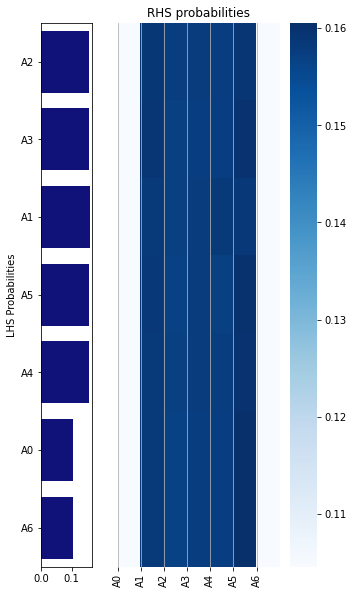

In [34]:
pwfts.visualize_distributions(model1)

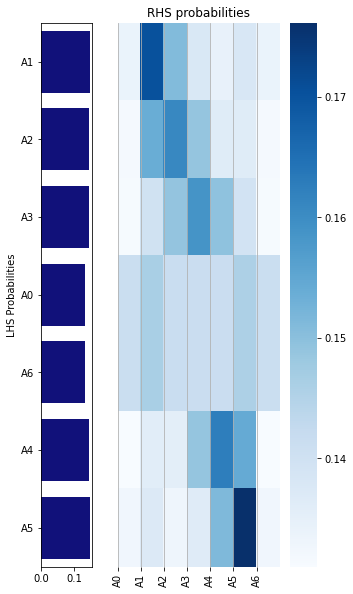

In [35]:
pwfts.visualize_distributions(model2)

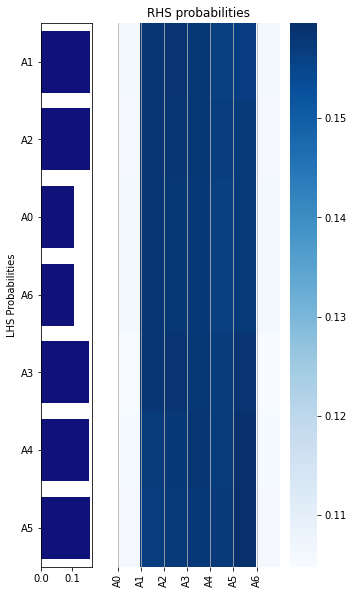

In [36]:
pwfts.visualize_distributions(model3)

ValueError: ignored

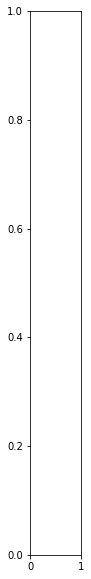

In [49]:
pwfts.visualize_distributions(model4)

In [50]:
#dataset = pd.read_excel('../content/sample_data/Base.xlsx')
#x = dataset.iloc[:,:-1].values
#y = dataset.iloc[:,-1].values
x = BaseT4[:,:-1]
y = BaseT4[:,-1]

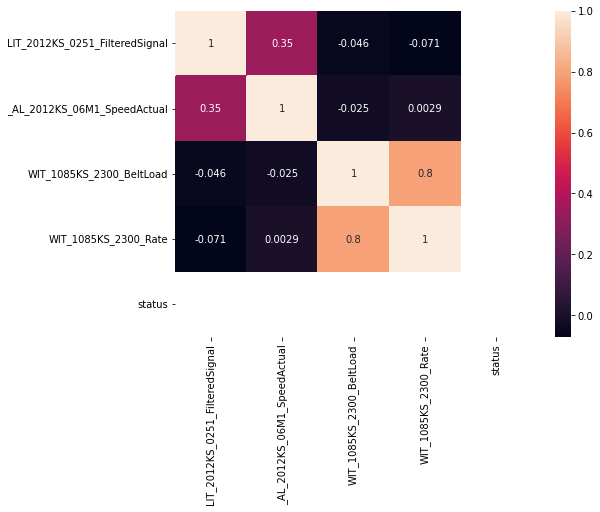

In [51]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dff.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

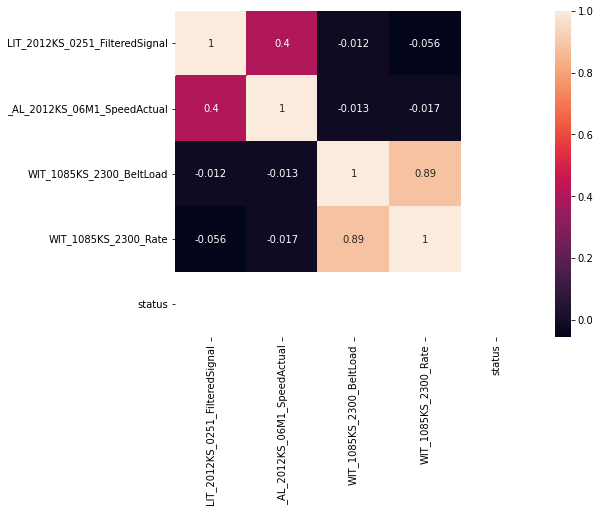

In [52]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dfn.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [53]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [54]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

XGBClassifier()

Matriz de confusão

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

[[ 6  9]
 [13  4]]


Precisão

In [56]:
accuracy_score(y_test, ypred)

0.3125

In [57]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 2)

print(accuracies.mean()*100)
print(accuracies.std()*100)

43.75
3.125
